### Описание Проекта

Нам доступны данные «Бета-Банка»  из которого стали уходить клиенты. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Необходимо спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 
Нужно построить модель с предельно большим значением F1-меры (мин значение - 0.59). самостоятельно.
Дополнительно измерить AUC-ROC.

   Данные:
   
    - RowNumber — индекс строки в данных
    - CustomerId — уникальный идентификатор клиента
    - Surname — фамилия
    - CreditScore — кредитный рейтинг
    - Geography — страна проживания
    - Gender — пол
    - Age — возраст
    - Tenure — сколько лет человек является клиентом банка
    - Balance — баланс на счёте
    - NumOfProducts — количество продуктов банка, используемых клиентом
    - HasCrCard — наличие кредитной карты
    - IsActiveMember — активность клиента
    - EstimatedSalary — предполагаемая зарплата
    
  Целевой признак:
  
    - Exited — факт ухода клиента
   

## Изучение данных

Импортируем библиотеки

In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

Загружаем данные:

In [2]:
import os

pth1 = 'Churn.csv'
pth2 = '/datasets/Churn.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [3]:
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Изучаем датафрейм:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Изучам столбцы, типы данных.

Переводим названия столбцов в нижний регистр

In [5]:
df.columns = df.columns.str.lower()

In [6]:
df.head(5)

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Проверяем дубликаты:

In [7]:
df.duplicated().sum()

0

Дубликатов нет

Проверяем налиие пропусков:

In [8]:
df.isnull().sum()

rownumber            0
customerid           0
surname              0
creditscore          0
geography            0
gender               0
age                  0
tenure             909
balance              0
numofproducts        0
hascrcard            0
isactivemember       0
estimatedsalary      0
exited               0
dtype: int64

Имеются пропуски - 909 шт встолбце 'tenure'. Это мого произойти из за ошибок привыгрузке. Удалить пропуски можно, но это может сказаться на обучении  и проверки моделей. По этому есть смысл заполнить пропуски.

изучаем  данные в столбце 'geography'

In [9]:
print(df['geography'].unique())

['France' 'Spain' 'Germany']


находим медианные значения того сколько человек является клиентом исходя из стран:

In [10]:
df[df['geography'] == 'Spain']['tenure'].median()

5.0

In [11]:
df[df['geography'] == 'Germany']['tenure'].median()

5.0

In [12]:
df[df['geography'] == 'France']['tenure'].median()

5.0

Медианное значение равняется - 5

Заполняем датафрем средним медианным значением

In [13]:
df = df.fillna(5)

In [14]:
df.head(5)

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Еще раз проверяем наличие пропусков

In [15]:
df.isnull().sum()

rownumber          0
customerid         0
surname            0
creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64

Пропусков нет

Изучим распределение целевого признака

In [16]:
pd.DataFrame({
    'count': df['exited'].value_counts(),
    'percent': df['exited'].value_counts() / len(df)
})

,count,percent
0,7963,0.7963
1,2037,0.2037


Видно что присутствует дисбаланс классов. Киентов которые ушли - 20%. Необходимо будет сбалансировать классы для обучения и тестирования моделей

Методом One-Hot Encoding  переводим категориальные значени в столбце  'gender' в численные

In [17]:

df_categorized = pd.get_dummies(df, columns=['gender'], drop_first=True)
df_categorized.head(5)



,rownumber,customerid,surname,creditscore,geography,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,gender_Male
0,1,15634602,Hargrave,619,France,42,2.0,0.00,1,1,1,101348.88,1,0
1,2,15647311,Hill,608,Spain,41,1.0,83807.86,1,0,1,112542.58,0,0
2,3,15619304,Onio,502,France,42,8.0,159660.80,3,1,0,113931.57,1,0
3,4,15701354,Boni,699,France,39,1.0,0.00,2,0,0,93826.63,0,0
4,5,15737888,Mitchell,850,Spain,43,2.0,125510.82,1,1,1,79084.10,0,0


Используя порядковое кодирование приводим значения в стобце 'geography' в численные

In [18]:
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(df_categorized),
                            columns=df_categorized.columns)
data_ordinal.head(5)


,rownumber,customerid,surname,creditscore,geography,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,gender_Male
0,0.0,2736.0,1115.0,228.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,5068.0,1.0,0.0
1,1.0,3258.0,1177.0,217.0,2.0,23.0,1.0,743.0,0.0,0.0,1.0,5639.0,0.0,0.0
2,2.0,2104.0,2040.0,111.0,0.0,24.0,8.0,5793.0,2.0,1.0,0.0,5707.0,1.0,0.0
3,3.0,5435.0,289.0,308.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4704.0,0.0,0.0
4,4.0,6899.0,1822.0,459.0,2.0,25.0,2.0,3696.0,0.0,1.0,1.0,3925.0,0.0,0.0


In [19]:
df_categorized['geography_cat'] = data_ordinal['geography']
df_categorized.head(5)

,rownumber,customerid,surname,creditscore,geography,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,gender_Male,geography_cat
0,1,15634602,Hargrave,619,France,42,2.0,0.00,1,1,1,101348.88,1,0,0.0
1,2,15647311,Hill,608,Spain,41,1.0,83807.86,1,0,1,112542.58,0,0,2.0
2,3,15619304,Onio,502,France,42,8.0,159660.80,3,1,0,113931.57,1,0,0.0
3,4,15701354,Boni,699,France,39,1.0,0.00,2,0,0,93826.63,0,0,0.0
4,5,15737888,Mitchell,850,Spain,43,2.0,125510.82,1,1,1,79084.10,0,0,2.0


меняем имя столбца на более подходящее

In [20]:
df_categorized.rename(columns={'gender_Male': 'gender'}, inplace=True)


In [21]:
df_categorized.head(5)

,rownumber,customerid,surname,creditscore,geography,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,gender,geography_cat
0,1,15634602,Hargrave,619,France,42,2.0,0.00,1,1,1,101348.88,1,0,0.0
1,2,15647311,Hill,608,Spain,41,1.0,83807.86,1,0,1,112542.58,0,0,2.0
2,3,15619304,Onio,502,France,42,8.0,159660.80,3,1,0,113931.57,1,0,0.0
3,4,15701354,Boni,699,France,39,1.0,0.00,2,0,0,93826.63,0,0,0.0
4,5,15737888,Mitchell,850,Spain,43,2.0,125510.82,1,1,1,79084.10,0,0,2.0


Проверяем уникальные значения в столбце 'geography_cat':

In [22]:
df_categorized['geography_cat'].unique()

array([0., 2., 1.])

Оставляем только столбцы с численными значениями необходимые для обучения моделей

In [23]:
df_analised = df_categorized[['creditscore', 'age', 'tenure', 'balance',  'numofproducts', 'hascrcard','isactivemember', 'estimatedsalary', 'gender', 'geography_cat', 'exited']]
df_analised.head(5)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,gender,geography_cat,exited
0,619,42,2.0,0.00,1,1,1,101348.88,0,0.0,1
1,608,41,1.0,83807.86,1,0,1,112542.58,0,2.0,0
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0.0,1
3,699,39,1.0,0.00,2,0,0,93826.63,0,0.0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,2.0,0


Приводим данные в столбцах к целочисленному типу 

In [24]:
df_analised[['tenure', 'geography_cat']] = df_analised[['tenure', 'geography_cat']].astype(dtype = int)

In [25]:
df_analised.head(5)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,gender,geography_cat,exited
0,619,42,2,0.00,1,1,1,101348.88,0,0,1
1,608,41,1,83807.86,1,0,1,112542.58,0,2,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,1
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,2,0


#### Вывод

Изучили данные датафрейма. Привели названия столбцов к нижнему регистру, обнаружили и заполнили пропуски в столбце 'Tenure'.

Выявили дисбаланс классов. 

Преобразовали категориальные признаки в численные. У нас было два столбца типа object, это столбцы geography и gender. Мы провели их кодирование с помощью техники One-Hot Encoding (прямого кодирования) и порядкового кодирования.



### Исследование задачи

Тк нам необходимо выяснить уйдет клиент или нет, то перед нами задача бинарной классификации. Целевой признак - 'exited', признаки - оставшиеся столбцы.

разделим выборку на: обучающую, валидную и тестовую

In [75]:
target = df_analised['exited']
features = df_analised.drop('exited', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345)

In [76]:
print('Размер обучающей выборки {}, от общего количества данных {:.1%}'.format(
    len(features_train), len(features_train)/features.shape[0]))
print('Размер тестовой выборки {}, от общего количества данных {:.1%}'.format(
    len(features_test), len(features_test)/features.shape[0]))

print('Размер валидной выборки {}, от общего количества данных {:.1%}'.format(
    len(features_valid), len(features_valid)/features.shape[0]))

Размер обучающей выборки 6000, от общего количества данных 60.0%
Размер тестовой выборки 2000, от общего количества данных 20.0%
Размер валидной выборки 2000, от общего количества данных 20.0%


### Исследуем модели

Обучаем следующие модели классификации на обучающей выборке:
    
    - Дерево Решений
    - Случайный лес
    - Логистическая регрессия

#### Модель Дерево Решений

In [28]:
best_depth_tree = 0
best_f1_tree = 0
best_roc_tree = 0


for depth in range(1, 17):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(features_train, target_train) 
    predictions_valid = model.predict(features_valid)
    
    predict = model.predict_proba(features_valid)
    predict_tree =   predict[:, 1]
    f1 = f1_score(target_valid, predictions_valid)
    roc_score = roc_auc_score(target_valid, predict_tree)

    if f1 > best_f1_tree:
        best_f1_tree = f1
        best_depth_tree = depth
        best_roc_tree = roc_score
        

print("Наилучший результат f1_score равен {:.2f}".format(best_f1_tree))
print("Максимальная глубина равна {}".format(best_depth_tree))
print("ROC_AUC_score равен {:.2f}".format(best_roc_tree))

Наилучший результат f1_score равен 0.53
Максимальная глубина равна 11
ROC_AUC_score равен 0.74


#### Модель Случайный лес

Обучим модель на тестовой выборке, тк данные не сбалансированы используем параметр class_weight со значением 'balanced'

In [29]:
best_f1_randomforest = 0
best_result_randomforest = 0
best_estimators = 0
best_depth_randomforest = 0
best_roc_randomforest = 0

for estimators in range(10,50,10):
    for depth in range(1, 15):
        model = RandomForestClassifier(random_state=12345, n_estimators=estimators,  max_depth=depth)
        model.fit(features_train, target_train) 
        predictions_valid = model.predict(features_valid) 
        
        predict = model.predict_proba(features_valid)
        predict_randomforest =  predict[:, 1]
        f1 = f1_score(target_valid, predictions_valid)
        roc_score = roc_auc_score(target_valid, predict_randomforest)
        
        if f1 > best_f1_randomforest:
            best_f1_randomforest = f1
            best_roc_randomforest = roc_score
            best_estimators = estimators
            best_depth_randomforest = depth 

In [30]:
print("Наилучший результат f1_score равен {:.2f}".format(best_f1_randomforest))
print("ROC_AUC_score равен {:.2f}".format(best_roc_randomforest))  
print("Максимальная глубина равна {}".format(best_depth_randomforest))
print("Количество деревьев равно {}".format(best_estimators))

Наилучший результат f1_score равен 0.57
ROC_AUC_score равен 0.83
Максимальная глубина равна 14
Количество деревьев равно 40


#### Модель Логистическая Регрессия

In [31]:
model = LogisticRegression()
model.fit(features_train, target_train) 
predictions_valid = model.predict(features_valid) 
predict = model.predict_proba(features_valid)
predict_lr =   predict[:, 1]
f1_lr = f1_score(target_valid, predictions_valid)
roc_score_lr = roc_auc_score(target_valid, predict_lr)

In [32]:
print("Наилучший результат f1_score равен {:.2f}".format(f1_lr))
print("ROC_AUC_score равен {:.2f}".format(roc_score_lr))  

Наилучший результат f1_score равен 0.10
ROC_AUC_score равен 0.68


Лучшая модель - Случайный лес

Наилучший результат f1_score равен 0.57

ROC_AUC_score равен 0.83

Максимальная глубина равна 14

Количество деревьев равно 40

Проверяем лучшую модель на тестовых данных

In [52]:
f1_randomforest_test = 0
roc_randomforest_test = 0

for estimators in range(10,50,10):
    for depth in range(1, 15):
        model = RandomForestClassifier(random_state=12345, n_estimators=estimators,  max_depth=depth)
        model.fit(features_train, target_train) 
        predictions_test = model.predict(features_test) 
        
        predict = model.predict_proba(features_test)
        predict_randomforest_test =  predict[:, 1]
        f1 = f1_score(target_valid, predictions_test)
        roc_score = roc_auc_score(target_test, predict_randomforest_test)
        
        if f1 > f1_randomforest_test:
            f1_randomforest_test = f1
            roc_randomforest_test = roc_score
            

print("Наилучший результат f1_score равен {:.2f}".format(f1_randomforest_test))
print("ROC_AUC_score равен {:.2f}".format(roc_randomforest_test)) 

Наилучший результат f1_score равен 0.18
ROC_AUC_score равен 0.85


Получили удручающий результат еще хуже ем на обучающей выборке. Это свзано с тем что данные не сбалансированы и не маштабированны

#### Маштабирование признаков

чтобы привести данные к балансу используем один из способов - приведение к одному масштабу при помощи StandardScaler из  библиотеки sklearn

In [58]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'creditscore', 'estimatedsalary']


scaler = StandardScaler()

pd.options.mode.chained_assignment = None

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
pd.options.mode.chained_assignment = None

features_train.head(5)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,gender,geography_cat
492,639.0,38.0,4.0,81550.940000,2,0,1,118974.770000,0,0
6655,554.0,44.0,5.0,85304.269999,1,1,1,58076.520001,1,0
4287,714.0,53.0,1.0,99141.859999,1,1,1,72496.050001,1,1
42,556.0,61.0,2.0,117419.350000,1,1,1,94153.830000,0,0
8178,707.0,46.0,7.0,127476.730000,2,1,1,146011.550000,0,0


Увеличение выборки необходимо для того чтобы уровнять классы. Для этого напишем функцию.

In [59]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [60]:
print(
    'Количество не ушедших пользователей в обучающей выборке {}шт, это {:.1%} от размера выборки'
    .format(target_upsampled[target_upsampled == 0].count(), 
            len(target_upsampled[target_upsampled == 0])/len(target_upsampled)))
print(
    'Количество ушедших пользователей в обучающей выборке {}шт, это {:.1%} от размера выборки'
    .format(target_upsampled.sum(), target_upsampled.mean()))

Количество не ушедших пользователей в обучающей выборке 4781шт, это 49.5% от размера выборки
Количество ушедших пользователей в обучающей выборке 4876шт, это 50.5% от размера выборки


Уменьшение выборки используется для того чтобы уменьшить тот класс, которого больше.

In [61]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.255)


In [62]:
print(
    'Количество не ушедших пользователей в обучающей выборке {}шт, это {:.1%} от размера выборки'
    .format(target_downsampled[target_downsampled == 0].count(), 
            len(target_downsampled[target_downsampled == 0])/len(target_downsampled)))
print(
    'Количество ушедших пользователей в обучающей выборке {}шт, это {:.1%} от размера выборки'
    .format(target_downsampled.sum(), target_downsampled.mean()))

Количество не ушедших пользователей в обучающей выборке 1219шт, это 50.0% от размера выборки
Количество ушедших пользователей в обучающей выборке 1219шт, это 50.0% от размера выборки


#### Вывод

1) Выяснили что, перед нами задача бинарной классификации. Выделили целевой признак - 'exited', признаки - оставшиеся столбцы.

Разделили выборку на: обучающую, валидную и тестовую.

2) Обучили модели:
   - Дерево Решений
   - Случайный лес
   - Логистическая регрессия
   
3)  Самый наилучший результата показала модель случайного леса с f1_score равным 0.57, что близко к требуемому значению и ROC_AUC_score равный 0.83, что говорит что модель не совсем плохо предсказывает верные значения.  

4) Протестировали лучшую модель на тестовых данных, получили плохие результаты.

5) Привели данные к одному масштабу про помощи StandardScaler из библиотеки sklearn

6) Написали функции для того чтобы привести классы к одному масштабу

### Обучение моделей сучетом баланса классов

#### Дерево Решений

Обучим модель на тестовой выборке, тк данные не сбалансированы используем параметр class_weight со значением 'balanced'

In [63]:
best_balansed_depth_tree = 0
best_balansed_f1_tree = 0
best_balansed_roc_tree = 0
best_balansed_tree_model = None

for depth in range(1, 17):
    balansed_tree_model = DecisionTreeClassifier(random_state=12345, class_weight = 'balanced', max_depth=depth) 
    balansed_tree_model.fit(features_train, target_train) 
    balansed_tree_predictions_valid = balansed_tree_model.predict(features_valid)
    
    predict_balansed_tree = balansed_tree_model.predict_proba(features_valid)
    predict_balansed_tree_1 =  predict_balansed_tree[:, 1]
    f1 = f1_score(target_valid, balansed_tree_predictions_valid)
    roc_score = roc_auc_score(target_valid, predict_balansed_tree_1)

    if f1 > best_balansed_f1_tree:
        best_balansed_f1_tree = f1
        best_balansed_depth_tree = depth
        best_balansed_roc_tree = roc_score
        best_balansed_tree_model = balansed_tree_model

print("Наилучший результат f1_score равен {:.2f}".format(best_balansed_f1_tree))
print("Максимальная глубина равна {}".format(best_balansed_depth_tree))
print("ROC_AUC_score равен {:.2f}".format(best_balansed_roc_tree))

Наилучший результат f1_score равен 0.56
Максимальная глубина равна 6
ROC_AUC_score равен 0.82


Проверяем модель на валибныхданных с балансированными данными методом upsempling

In [64]:
best_depth_tree_upsampled = 0
best_f1_tree_upsampled = 0
best_roc_tree_upsampled = 0
best_upsampled_tree = None

for depth in range(1, 17):
    upsampled_model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    upsampled_model.fit(features_upsampled, target_upsampled) 
    upsampled_predictions_valid = upsampled_model.predict(features_valid)
    
    upsampled_model_predict = upsampled_model.predict_proba(features_valid)
    upsampled_predict_tree =   upsampled_model_predict[:, 1]
    f1_upsampled = f1_score(target_valid, upsampled_predictions_valid)
    roc_score_upsampled = roc_auc_score(target_valid, upsampled_predict_tree)

    if f1_upsampled > best_f1_tree_upsampled:
        best_f1_tree_upsampled = f1
        best_depth_tree_upsampled = depth
        best_roc_tree_upsampled = roc_score_upsampled
        best_upsampled_tree = upsampled_model

print("Наилучший результат f1_score равен {:.2f}".format(best_f1_tree_upsampled))
print("Максимальная глубина равна {}".format(best_depth_tree_upsampled))
print("ROC_AUC_score равен {:.2f}".format(best_roc_tree_upsampled))

Наилучший результат f1_score равен 0.49
Максимальная глубина равна 16
ROC_AUC_score равен 0.70


Модель не улучшила результат и показала f1_score - 0.49 ниже чем  тестовая сбалансированная модель 

Проверяем модель на валибныхданных с балансированными данными методом downsempling

In [65]:
best_depth_tree_downsampled = 0
best_f1_tree_downsampled = 0
best_roc_tree_downsampled = 0
best_downsampled_tree = None

for depth in range(1, 17):
    downsampled_model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    downsampled_model.fit(features_upsampled, target_upsampled) 
    downsampled_predictions_valid = downsampled_model.predict(features_valid)
    
    downsampled_predict = downsampled_model.predict_proba(features_valid)
    downsampled_predict_tree =  downsampled_predict[:, 1]
    f1_downsampled = f1_score(target_valid, downsampled_predictions_valid)
    roc_score_downsampled = roc_auc_score(target_valid, downsampled_predict_tree)

    if f1_upsampled > best_f1_tree_downsampled:
        best_f1_tree_downsampled = f1
        best_depth_tree_downsampled = depth
        best_roc_tree_downsampled = roc_score_downsampled
        best_downsampled_tree = downsampled_model

print("Наилучший результат f1_score равен {:.2f}".format(best_f1_tree_downsampled))
print("Максимальная глубина равна {}".format(best_depth_tree_downsampled))
print("ROC_AUC_score равен {:.2f}".format(best_roc_tree_downsampled))

Наилучший результат f1_score равен 0.49
Максимальная глубина равна 16
ROC_AUC_score равен 0.70


Модель так же не улучшила результат

#### Модель Случайный лес

Обучим модель на тестовой выборке, тк данные не сбалансированы используем параметр class_weight со значением 'balanced'

In [66]:
best_balansed_f1_randomforest = 0
best_balansed_result_randomforest = 0
best_balansed_estimators = 0
best_balansed_depth_randomforest = 0
best_balansed_roc_randomforest = 0
best_balansed_model = None

for estimators in range(10,50,10):
    for depth in range(1, 15):
        balansed_random_forest_model = RandomForestClassifier(random_state=12345, n_estimators=estimators, 
                                                              class_weight='balanced', max_depth=depth)
        balansed_random_forest_model.fit(features_train, target_train) 
        balansed_predictions_valid = balansed_random_forest_model.predict(features_valid) 
        
        balansed_predict = balansed_random_forest_model.predict_proba(features_valid)
        predict_balansed_randomforest =  balansed_predict[:, 1]
        f1 = f1_score(target_valid, balansed_predictions_valid)
        roc_score = roc_auc_score(target_valid, predict_balansed_randomforest)
        
        if f1 > best_balansed_f1_randomforest:
            best_balansed_f1_randomforest = f1
            best_balansed_roc_randomforest = roc_score
            best_balansed_estimators = estimators
            best_balansed_depth_randomforest = depth 
            balansed_random_forest_model = best_balansed_model
            
            
print("Наилучший результат f1_score равен {:.2f}".format(best_balansed_f1_randomforest))
print("ROC_AUC_score равен {:.2f}".format(best_balansed_roc_randomforest))  
print("Максимальная глубина равна {}".format(best_balansed_depth_randomforest))
print("Количество деревьев равно {}".format(best_balansed_estimators))            

Наилучший результат f1_score равен 0.58
ROC_AUC_score равен 0.85
Максимальная глубина равна 11
Количество деревьев равно 40


Проверяем модель на валибныхданных с балансированными данными методом upsempling

In [67]:
best_upsampled_f1_randomforest = 0
best_upsampled_result_randomforest = 0
best_upsampled_estimators = 0
best_upsampled_depth_randomforest = 0
best_upsampled_roc_randomforest = 0
best_upsampled_model = None

for estimators in range(10,50,10):
    for depth in range(1, 15):
        upsampled_random_forest_model = RandomForestClassifier(random_state=12345, n_estimators=estimators, 
                                                               max_depth=depth)
        upsampled_random_forest_model.fit(features_upsampled, target_upsampled) 
        upsampled_predictions_valid = upsampled_random_forest_model.predict(features_valid) 
        
        upsampled_predict = upsampled_random_forest_model.predict_proba(features_valid)
        predict_upsampled_randomforest =  upsampled_predict[:, 1]
        f1 = f1_score(target_valid, upsampled_predictions_valid)
        roc_score = roc_auc_score(target_valid, predict_upsampled_randomforest)
        
        if f1 > best_upsampled_f1_randomforest:
            best_upsampled_f1_randomforest = f1
            best_upsampled_roc_randomforest = roc_score
            best_upsampled_estimators = estimators
            best_upsampled_depth_randomforest = depth 
            best_upsampled_model = upsampled_random_forest_model
            
print("Наилучший результат f1_score равен {:.2f}".format(best_upsampled_f1_randomforest))
print("ROC_AUC_score равен {:.2f}".format(best_upsampled_roc_randomforest))  
print("Максимальная глубина равна {}".format(best_upsampled_depth_randomforest))
print("Количество деревьев равно {}".format(best_upsampled_estimators))  


Наилучший результат f1_score равен 0.60
ROC_AUC_score равен 0.85
Максимальная глубина равна 12
Количество деревьев равно 30


RandomForestClassifier(max_depth=12, n_estimators=30, random_state=12345)

Модель сбалансированная метотодм upsempling показала результаты лучше чем  модель с параметром class_weight со значением 'balanced'

Проверяем модель на валибныхданных с балансированными данными методом downsampling

In [68]:
best_downsampled_f1_randomforest = 0
best_downsampled_result_randomforest = 0
best_downsampled_estimators = 0
best_downsampled_depth_randomforest = 0
best_downsampled_roc_randomforest = 0
best_downsampled_model = None

for estimators in range(10,50,10):
    for depth in range(1, 15):
        downsampled_random_forest_model = RandomForestClassifier(random_state=12345, n_estimators=estimators, 
                                                               max_depth=depth)
        downsampled_random_forest_model.fit(features_downsampled, target_downsampled) 
        downsampled_predictions_valid = downsampled_random_forest_model.predict(features_valid) 
        
        downsampled_predict = downsampled_random_forest_model.predict_proba(features_valid)
        predict_downsampled_randomforest =  downsampled_predict[:, 1]
        f1 = f1_score(target_valid, downsampled_predictions_valid)
        roc_score = roc_auc_score(target_valid, predict_downsampled_randomforest)
        
        if f1 > best_downsampled_f1_randomforest:
            best_downsampled_f1_randomforest = f1
            best_downsampled_roc_randomforest = roc_score
            best_downsampled_estimators = estimators
            best_downsampled_depth_randomforest = depth 
            best_downsampled_model = downsampled_random_forest_model
            
print("Наилучший результат f1_score равен {:.2f}".format(best_downsampled_f1_randomforest))
print("ROC_AUC_score равен {:.2f}".format(best_downsampled_roc_randomforest))  
print("Максимальная глубина равна {}".format(best_downsampled_depth_randomforest))
print("Количество деревьев равно {}".format(best_downsampled_estimators))  

Наилучший результат f1_score равен 0.57
ROC_AUC_score равен 0.84
Максимальная глубина равна 14
Количество деревьев равно 30


Модель сбалансированная метотодм downsempling показала результаты хуже чем модель с параметром class_weight со значением 'balanced'

#### Линейная регрессия

Обучим модель на тестовой выборке используя параметры solver='liblinear', class_weight со значением 'balanced'

In [80]:
balansed_lr_model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=12345)
balansed_lr_model.fit(features_train, target_train) 
balansed_predictions_valid = balansed_lr_model.predict(features_valid) 
balansed_predict = balansed_lr_model.predict_proba(features_valid)
balansed_predict_lr =   balansed_predict[:, 1]
balansed_f1_lr = f1_score(target_valid, balansed_predictions_valid)
balansed_roc_score_lr = roc_auc_score(target_valid, balansed_predict_lr)



print("Наилучший результат f1_score равен {:.2f}".format(balansed_f1_lr))
print("ROC_AUC_score равен {:.2f}".format(balansed_roc_score_lr))  

Наилучший результат f1_score равен 0.44
ROC_AUC_score равен 0.72


Проверяем модель на валибныхданных с балансированными данными методом upsempling

In [81]:
upsampled_lr_model = LogisticRegression(solver='liblinear', random_state=12345)
upsampled_lr_model.fit(features_upsampled, target_upsampled) 
upsampled_lr_predictions_valid = upsampled_lr_model.predict(features_valid) 
upsampled_lr_predict = upsampled_lr_model.predict_proba(features_valid)
upsampled_lr_predict_lr =   predict[:, 1]
upsampled_f1_lr = f1_score(target_valid, upsampled_lr_predictions_valid)
upsampled_roc_score_lr = roc_auc_score(target_valid, upsampled_lr_predict_lr)

print("Наилучший результат f1_score равен {:.2f}".format(upsampled_f1_lr))
print("ROC_AUC_score равен {:.2f}".format(upsampled_roc_score_lr))  

Наилучший результат f1_score равен 0.43
ROC_AUC_score равен 0.51


Модель сбалансированная метотодм upsempling показала результаты хуже чем изначальная модель 

Проверяем модель на валибныхданных с балансированными данными методом downsempling

In [82]:
downsampled_lr_model = LogisticRegression(solver='liblinear', random_state=12345)
downsampled_lr_model.fit(features_downsampled, target_downsampled) 
downsampled_lr_predictions_valid = downsampled_lr_model.predict(features_valid) 
downsampled_lr_predict = downsampled_lr_model.predict_proba(features_valid)
downsampled_lr_predict_lr = downsampled_lr_predict[:, 1]
downsampled_f1_lr = f1_score(target_valid, downsampled_lr_predictions_valid)
downsampled_roc_score_lr = roc_auc_score(target_valid, downsampled_lr_predict_lr)

print("Наилучший результат f1_score равен {:.2f}".format(downsampled_f1_lr))
print("ROC_AUC_score равен {:.2f}".format(downsampled_roc_score_lr))  

Наилучший результат f1_score равен 0.43
ROC_AUC_score равен 0.72


Модель сбалансированная метотодм downsempling показала результаты хуже чем изначальная модель 

#### Вывод

Было обучено следующие модели машинного обучения:

  - Логистическая регрессия
  - Дерево решений
  - Случайный лес
  
  
При обучении использовали следующие методы:

  - Примененили параметра class_weight = balanced
  - Увеличили выборки методом upsampling
  - Уменьшили выборки методом downsampling
  
  
Наилучший результат  показала модель случайного леса ее F1_score равен 0.60 с ROC_AUC_score равным 0.85 с применение метода увеличение выборки методом upsampling и применение параметра class_weight = balanced.

У дерева решений наилучший F1_score равен 0.56, а ROC_AUC_score равен 0.82 с применением  параметра class_weight = balanced.

У логистической регресии наилучший F1_score равен f1_score равен 0.44, аROC_AUC_score равен 0.72  используя параметры solver='liblinear', class_weight со значением 'balanced'

Тк в задании  порог F1_score  установлен в 0.59 смогла только модель случайного леса, поэтому на ней и будем тестировать наш тестовый набор данных.


### Тестирование модели

Берем лучшую модель - Случайный лесь и проверяем ее на тестовой выборке

In [73]:
predict_test = best_upsampled_model.predict(features_test)
predict_proba = best_upsampled_model.predict_proba(features_test)
predict_proba_ones = predict_proba[:, 1]

f1 = f1_score(target_test, predict_test)
roc_score = roc_auc_score(target_test, predict_proba_ones)

print("Результат f1_score на тестовой выборке равен {:.2f}".format(f1))
print("ROC_AUC_score на тестовой выборке равен {:.2f}".format(roc_score))  




Результат f1_score на тестовой выборке равен 0.61
ROC_AUC_score на тестовой выборке равен 0.86


Мы получили f1_score на тестовой выборке - 0.61, который больше проходного значения,  и ROC_AUC_score - 0.86 который близко к 1.
Значит данная модель очень хорошо предсказывает результаты

Отобразим на диаграмме в порядке убывания параметры которые важны для предсказания уйдет клиент или нет

<AxesSubplot:>

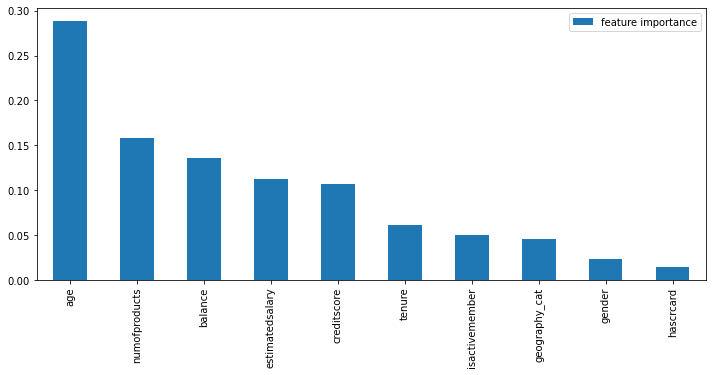

In [85]:
important= pd.DataFrame(
    best_upsampled_model.feature_importances_,
    index=features_train.columns,
    columns=['feature importance']).sort_values('feature importance',
                                                ascending=False)
important.plot(kind='bar', figsize=(12,5))

## Общий вывод

Изучив  данные «Бета-Банка» из которого стали уходить клиенты, наша цель была спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нужно было построить модель с предельно большим значением F1-меры (мин значение - 0.59) и дополнительно измерить AUC-ROC.

Изучили столбцы и типы данных, привели названия столбцов в нижний регистр.
Проверили дубликаты - дубликатов нет. Проверили налиие пропусков. Оказалось их 909 в столбце 'tenure'. Это мого произойти из за ошибок привыгрузке. Удалить пропуски можно, но это может сказаться на обучении и проверки моделей. По этому есть смысл заполнить пропуски. Заполнили датафрем средним медианным значением.

Видно что присутствует дисбаланс классов. Киентов которые ушли - 20%.  В дальнейшем   сбалансировали  классы для обучения и тестирования моделей

Методом One-Hot Encoding перевели категориальные значени в столбце 'gender' в численные. Используя порядковое кодирование привели значения в стобце 'geography' в численные.

Удалили столбцы RowNumber, CustomerId, Surname так как для дальнейшего анализа они нам будут не нужны.

Тк нам необходимо выяснить уйдет клиент или нет, то перед нами задача бинарной классификации. Целевой признак - 'exited', признаки - оставшиеся столбцы. разделили выборку на: обучающую, валидную и тестовую

Обучили следующие модели классификации на обучающей выборке:

- Дерево Решений
- Случайный лес
- Логистическая регрессия

Самый наилучший результата показала модель случайного леса с f1_score равным 0.57, что близко к требуемому значению и ROC_AUC_score равный 0.83, что говорит что модель не совсем плохо предсказывает верные значения.

Протестировали лучшую модель на тестовых данных, получили плохие результаты.

Привели данные к одному масштабу при помощи StandardScaler из библиотеки sklearn

Написали функции для того чтобы привести классы к одному масштабу

При обучении использовали следующие методы:

  - Примененили параметра class_weight = balanced
  - Увеличили выборки методом upsampling
  - Уменьшили выборки методом downsampling
  
  
Наилучший результат  показала модель случайного леса ее F1_score равен 0.60 с ROC_AUC_score равным 0.85 с применение метода увеличение выборки методом upsampling и применение параметра class_weight = balanced.

У дерева решений наилучший F1_score равен 0.56, а ROC_AUC_score равен 0.82 с применением  параметра class_weight = balanced.

У логистической регресии наилучший F1_score равен f1_score равен 0.44, аROC_AUC_score равен 0.72  используя параметры solver='liblinear', class_weight со значением 'balanced'

Тк в задании  порог F1_score  установлен в 0.59 смогла только модель случайного леса, поэтому на ней и будем тестировать наш тестовый набор данных.

На этапе Тестирования модели - взяи лучшую модель - Случайный лес и проверили ее на тестовой выборке.


Мы получили f1_score на тестовой выборке - 0.61, который больше проходного значения, и ROC_AUC_score - 0.86 который близко к 1. Значит данная модель очень хорошо предсказывает результаты